# scikit-HEROS: Models With Noisy Data Notebook
This notebook is set up as a demonstration for running scikit-HEROS.


***
## Imports:

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from sklearn.metrics import classification_report
# If pip installed
#from skheros.heros import HEROS
# If locally run
from src.skheros.heros import HEROS

current_working_directory = os.getcwd()
print(current_working_directory)

/Users/gabe/scikit-heros


***
## Set Up Local Run Parameters


In [2]:
local_save = True
folder_path = './output'
output_name = 'demo'
if not os.path.exists(folder_path):
        os.makedirs(folder_path)
if local_save:
    output_folder = './output'
else:
    output_folder = folder_path

***
# Data

### Load Example Dataset (B-Gametes)

In [3]:
df = pd.read_csv('/Users/gabe/scikit-heros/test/datasets/D_gametes_2way_epistasis_L_2_H_0.4_EDM-2_01.csv')
outcome_label = 'Class'

print(df)

      N0  N1  N2  N3  N4  N5  N6  N7  N8  N9  ...  N91  N92  N93  N94  N95  \
0      1   0   0   1   0   0   0   1   0   0  ...    0    0    0    1    2   
1      1   0   0   0   0   1   0   1   0   0  ...    0    0    0    1    0   
2      0   0   0   1   0   1   0   1   0   0  ...    0    0    0    2    1   
3      0   1   0   1   0   0   0   0   0   1  ...    0    0    0    1    0   
4      1   0   1   0   2   0   0   0   0   0  ...    0    0    0    0    0   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...   
1595   0   1   0   0   0   2   0   0   0   1  ...    0    1    0    0    0   
1596   1   1   0   0   0   2   0   0   0   1  ...    0    0    0    1    1   
1597   0   0   0   0   0   0   0   0   0   2  ...    0    0    0    0    1   
1598   1   2   0   0   2   1   0   1   0   0  ...    0    0    0    1    1   
1599   0   0   0   1   1   1   0   0   0   1  ...    0    0    0    1    2   

      N96  N97  M0P0  M0P1  Class  
0       1    0     0     0 

### Prepare Dataset for Analysis
Data used for training HEROS has the following requirements:
1. The training data must be passed as separate array-like objects including:
    1. 'X' {n_samples, n_quanatiative_features} Training instances of features to be treated as quantitative (must be numeric).
    2. 'Xc' {n_samples, n_categorical_features} Training instances of features to be treated as categorical (numeric recommended, but non-numeric will be numerically encoded).
    3. 'y' {n_samples} Training labels of the outcome variable.
2. Either 'X', 'Xc', or both must be provided.
3. 'y must always be provided and must not include any missing values.
4. Missing values are allowed in 'X' or 'Xc' but data instances should be excluded that have missing values for all features. Note, HEROS treats missing values as missing, i.e. no imputation of values are made or needed. Any rule that specifies a given feature will not match an instance with a missing value at that instance. 
5. (OPTIONAL) 'pop_df' is a DataFrame of a previously trained HEROS rule population that can be uploaded to initialize a new HEROS run.
6. (OPTIONAL) 'ek' is a numpy array or list of expert knowledge weights for all quantitative and categorical features in the dataset. They must be formatted as follows:
    1. This list must have the same number of elements as there are total features in the dataset (ordered in the same way)
    2. If a mix of quantiative and categorical features are loaded, HEROS will combine them with all quantitative features first, followed by all categorical features in the same order as provided in 'X' or 'Xc'.



In [4]:
from sklearn.model_selection import train_test_split

X = df.drop(outcome_label, axis=1)
y = df[outcome_label]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
columns = df.columns.values.tolist()
print(columns)
feature_names = X_train.columns
cat_feat_indexes = list(range(X_train.shape[1])) 
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values
print(X)
print(type(X))
ek = None

['N0', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N16', 'N17', 'N18', 'N19', 'N20', 'N21', 'N22', 'N23', 'N24', 'N25', 'N26', 'N27', 'N28', 'N29', 'N30', 'N31', 'N32', 'N33', 'N34', 'N35', 'N36', 'N37', 'N38', 'N39', 'N40', 'N41', 'N42', 'N43', 'N44', 'N45', 'N46', 'N47', 'N48', 'N49', 'N50', 'N51', 'N52', 'N53', 'N54', 'N55', 'N56', 'N57', 'N58', 'N59', 'N60', 'N61', 'N62', 'N63', 'N64', 'N65', 'N66', 'N67', 'N68', 'N69', 'N70', 'N71', 'N72', 'N73', 'N74', 'N75', 'N76', 'N77', 'N78', 'N79', 'N80', 'N81', 'N82', 'N83', 'N84', 'N85', 'N86', 'N87', 'N88', 'N89', 'N90', 'N91', 'N92', 'N93', 'N94', 'N95', 'N96', 'N97', 'M0P0', 'M0P1', 'Class']
      N0  N1  N2  N3  N4  N5  N6  N7  N8  N9  ...  N90  N91  N92  N93  N94  \
0      1   0   0   1   0   0   0   1   0   0  ...    1    0    0    0    1   
1      1   0   0   0   0   1   0   1   0   0  ...    1    0    0    0    1   
2      0   0   0   1   0   1   0   1   0   0  ...    0    0    0

***
# Run HEROS (Training)


In [5]:
heros_null = HEROS(outcome_type='class',iterations=10000, pop_size=500, cross_prob=0.8, mut_prob=0.04, nu=1, beta=0.2, theta_sel=0.5,
              fitness_function='pareto',subsumption='both', use_ek=False, rsl=None, feat_track='end', model_iterations=100,
              model_pop_size=100, new_gen=1.0, merge_prob=0.1, pop_init_type=None, compaction='sub',
              track_performance=1000,random_state=42, verbose=True, prob = False)

heros_null = heros_null.fit(X_train, y_train, cat_feat_indexes=cat_feat_indexes, ek=ek)


Data Manage Summary: ------------------------------------------------
Number of quantitative features: 0
Number of categorical features: 100
Total Features: 100
Total Instances: 1280
Feature Types: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Missing Values: 0
Classes: [0, 1]
Class Counts: {0: 651, 1: 629}
Class Weights: {0: 0.49140625000000004, 1: 0.50859375}
Majority Class: 0
Quantiative Feature Range: [[inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf

In [6]:
"""from sklearn.model_selection import train_test_split

df = pd.read_csv('/Users/gabe/Downloads/GAMETES_set/B_gametes_uni_4add_L_1_H_0.4_EDM-2_01.csv')
outcome_label = 'Class'

X = df.drop(outcome_label, axis=1)
y = df[outcome_label]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
columns = df.columns.values.tolist()
print(columns)
feature_names = X_train.columns
cat_feat_indexes = list(range(X_train.shape[1])) 
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values
print(X)
print(type(X))
ek = None"""

"from sklearn.model_selection import train_test_split\n\ndf = pd.read_csv('/Users/gabe/Downloads/GAMETES_set/B_gametes_uni_4add_L_1_H_0.4_EDM-2_01.csv')\noutcome_label = 'Class'\n\nX = df.drop(outcome_label, axis=1)\ny = df[outcome_label]\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\ncolumns = df.columns.values.tolist()\nprint(columns)\nfeature_names = X_train.columns\ncat_feat_indexes = list(range(X_train.shape[1])) \nX_train = X_train.values\ny_train = y_train.values\nX_test = X_test.values\ny_test = y_test.values\nprint(X)\nprint(type(X))\nek = None"

In [7]:

heros_alt = HEROS(outcome_type='class',iterations=10000, pop_size=500, cross_prob=0.8, mut_prob=0.04, nu=1, beta=0.2, theta_sel=0.5,
              fitness_function='pareto',subsumption='both', use_ek=False, rsl=None, feat_track='end', model_iterations=100,
              model_pop_size=100, new_gen=1.0, merge_prob=0.1, pop_init_type=None, compaction='sub',
              track_performance=1000,random_state=42, verbose=True, prob = True)
heros_alt = heros_alt.fit(X_train, y_train, cat_feat_indexes=cat_feat_indexes, ek=ek)


Data Manage Summary: ------------------------------------------------
Number of quantitative features: 0
Number of categorical features: 100
Total Features: 100
Total Instances: 1280
Feature Types: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Missing Values: 0
Classes: [0, 1]
Class Counts: {0: 651, 1: 629}
Class Weights: {0: 0.49140625000000004, 1: 0.50859375}
Majority Class: 0
Quantiative Feature Range: [[inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf

In [8]:
heros_alt1 = HEROS(outcome_type='class',iterations=10000, pop_size=500, cross_prob=0.8, mut_prob=0.04, nu=1, beta=0.2, theta_sel=0.5,
              fitness_function='pareto',subsumption='both', use_ek=False, rsl=None, feat_track='end', model_iterations=100,
              model_pop_size=100, new_gen=1.0, merge_prob=0.1, pop_init_type=None, compaction='sub',
              track_performance=1000,random_state=42, verbose=True, prob = None)
heros_alt1 = heros_alt1.fit(X_train, y_train, cat_feat_indexes=cat_feat_indexes, ek=ek)

Data Manage Summary: ------------------------------------------------
Number of quantitative features: 0
Number of categorical features: 100
Total Features: 100
Total Instances: 1280
Feature Types: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Missing Values: 0
Classes: [0, 1]
Class Counts: {0: 651, 1: 629}
Class Weights: {0: 0.49140625000000004, 1: 0.50859375}
Majority Class: 0
Quantiative Feature Range: [[inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf

KeyboardInterrupt: 

*** 
# HEROS Trained Rule Population (Same for both null and alt)

### Get DataFrame and save to .csv

In [9]:
pop_df = heros_null.get_pop()
print(pop_df)
pop_df.to_csv(output_folder+'/'+str(output_name)+'_rule_pop.csv', index=False)

       ID             Condition Indexes       Condition Values  Action  \
0      39                          [49]                    [1]       0   
1    2597                          [32]                    [0]       0   
2    2778                          [39]                    [0]       1   
3    2581                          [54]                    [0]       1   
4    2243                      [32, 39]                 [0, 1]       0   
..    ...                           ...                    ...     ...   
266  2788    [5, 8, 13, 25, 49, 54, 56]  [1, 0, 0, 0, 0, 0, 0]       1   
267  2784  [13, 21, 27, 39, 53, 76, 88]  [0, 0, 0, 1, 0, 1, 0]       0   
268  2758   [2, 21, 25, 27, 32, 53, 88]  [0, 0, 0, 0, 0, 0, 0]       0   
269  2814   [8, 13, 25, 39, 54, 56, 94]  [0, 0, 0, 0, 0, 0, 1]       1   
270  2807  [11, 13, 22, 50, 54, 56, 98]  [0, 0, 0, 1, 0, 0, 0]       1   

     Numerosity   Fitness  Useful Accuracy  Useful Coverage  Accuracy  \
0             1  0.735297         0.07

### Visualize Rule Population on Pareto Front Fitness Landscape

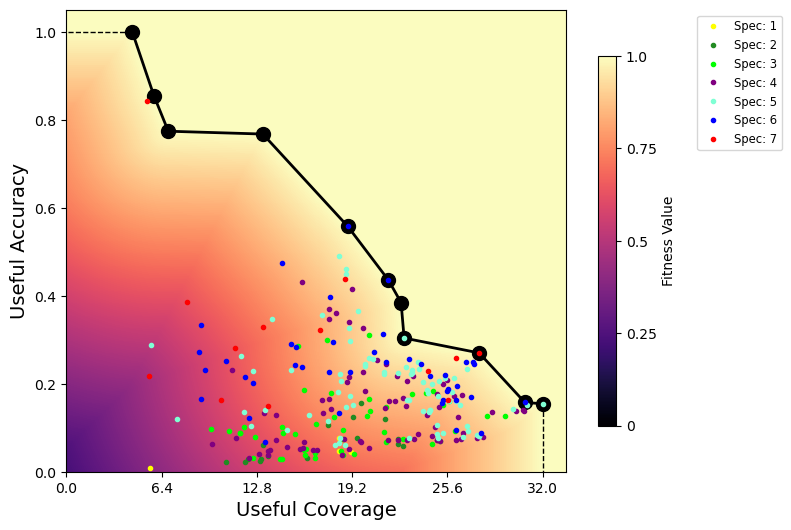

In [10]:
resolution = 500
plot_rules = True
color_rules = True
heros_null.rule_pareto.plot_pareto_landscape(resolution, heros_null.rule_population, plot_rules, color_rules,heros_null, show=True,save=True,output_path=folder_path,data_name=output_name)

### Visualize Rule Population (Feature Specification) as a Rule-Clustered Heatmap (With Optional Rule-Weighting)

Parameters:

feature_names: a list of feature names for the entire training dataset (given in original dataset order)
weighting: indicates what (if any) weighting is applied to individual rules for the plot ('useful_accuracy', 'fitness', None)
specified_filter: the number of times a given feature must be specified in rules of the population to be included in the plot (must be a positive integer or None)
display_micro: controls whether or not additional copies of rules (based on rule numerosity) should be included in the heatmap (True or False)
show: indicates whether or not to show the plot (True or False)
save: indicates whether or not to save the plot to a specified path/filename (True or False)
output_path: a valid folder path within which to save the plot (str of folder path)
data_name: a unique name precursor to give to the plot (str)

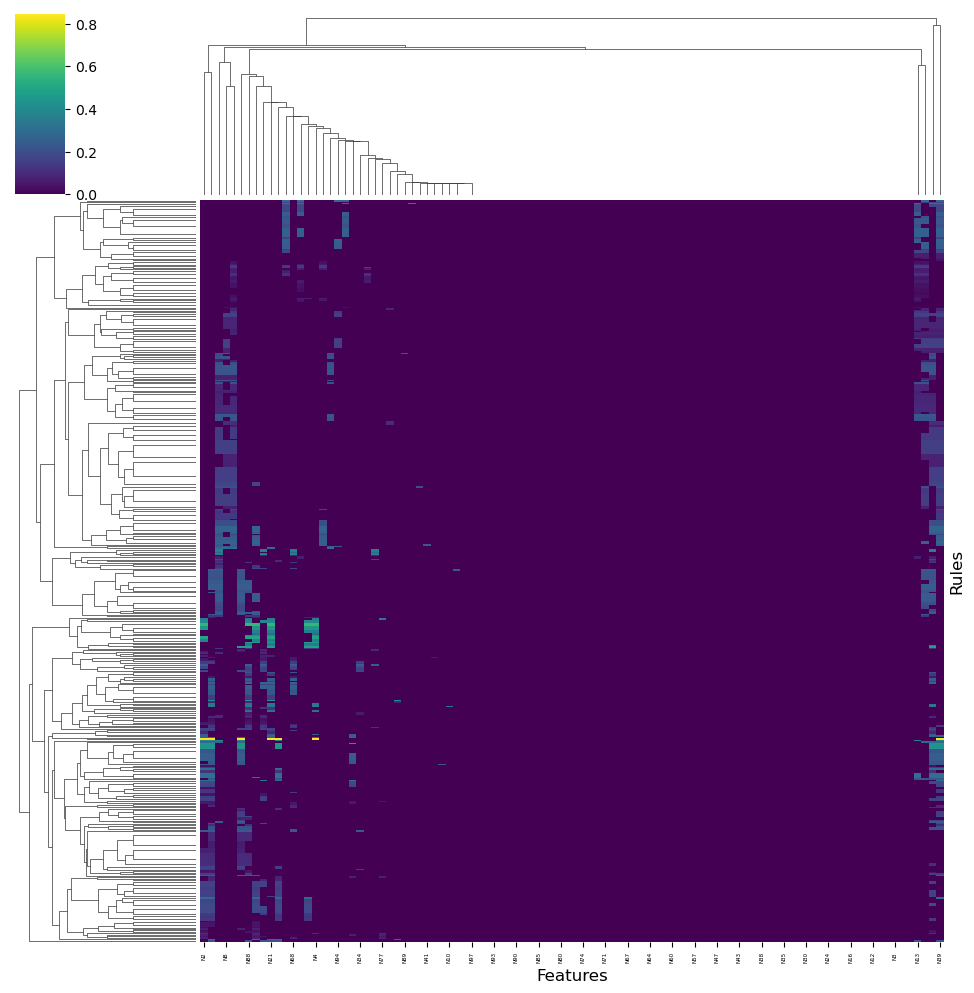

In [ ]:
heros_null.rule_population.plot_rule_pop_heatmap(feature_names, heros_null, weighting='useful_accuracy', specified_filter=None, display_micro=True, show=True, save=True, output_path=folder_path, data_name=output_name)

### Visualize Rule Population (Feature Specification) as a Network (With Optional Rule-Weighting)

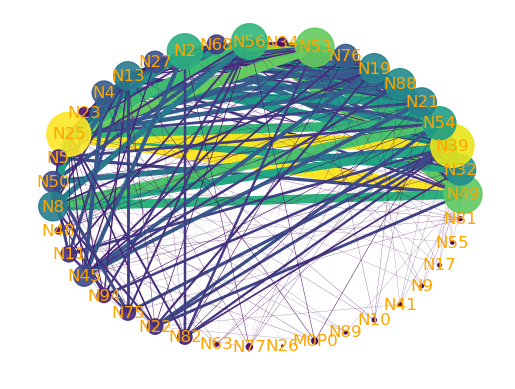

In [ ]:
node_size = 1000
edge_size = 10
weighting = 'useful_accuracy'# 'useful_accuracy', 'fitness', None
display_micro = True
heros_null.rule_population.plot_rule_pop_network(feature_names, weighting=weighting, display_micro=display_micro, node_size=node_size, edge_size=edge_size, show=True, save=True, output_path=folder_path, data_name=output_name)


***
# HEROS Model Population Insights

### Null

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


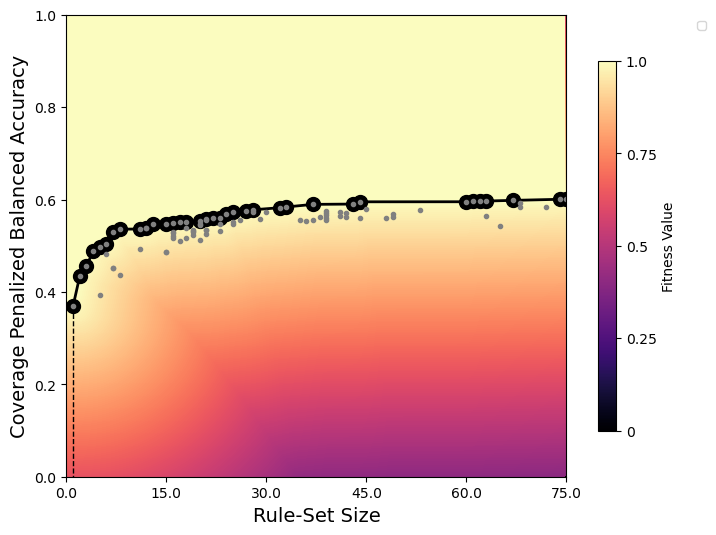

In [11]:
resolution = 500
plot_models = True
heros_null.model_pareto.plot_pareto_landscape(resolution, heros_null.model_population, plot_models, heros_null, show=True,save=True,output_path=folder_path,data_name=output_name)

### Alt

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


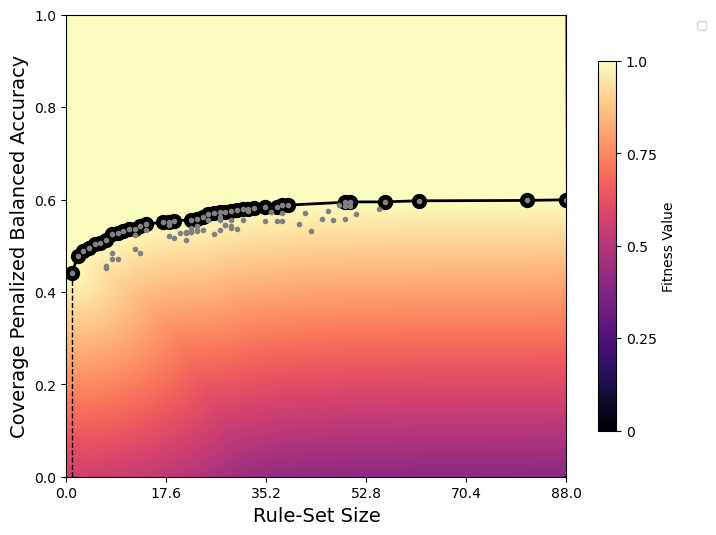

In [12]:
resolution = 500
plot_models = True
heros_alt.model_pareto.plot_pareto_landscape(resolution, heros_alt.model_population, plot_models, heros_alt, show=True,save=True,output_path=folder_path,data_name=output_name)

*** 
# HEROS Top Trained Model Insights

### Null

In [ ]:
set_df = heros_null.get_top_model_rules()
set_df.to_csv(output_folder+'/'+str(output_name)+'_top_model_rules.csv', index=False)
print(set_df)

           Condition Indexes    Condition Values  Action  Numerosity  \
0                   [19, 53]              [0, 0]       0           1   
1                   [32, 53]              [0, 0]       0           5   
2        [2, 19, 27, 53, 76]     [0, 0, 0, 0, 1]       0           2   
3        [8, 25, 39, 49, 54]     [0, 0, 0, 0, 0]       1          10   
4                [2, 27, 49]           [0, 0, 1]       0           1   
..                       ...                 ...     ...         ...   
70                  [32, 76]              [0, 1]       0           1   
71   [2, 19, 39, 45, 53, 76]  [0, 0, 1, 0, 0, 1]       0           1   
72            [2, 4, 19, 21]        [0, 0, 0, 0]       0           2   
73  [25, 32, 49, 53, 56, 88]  [0, 0, 1, 0, 0, 0]       0           4   
74          [39, 49, 54, 56]        [0, 0, 0, 0]       1           4   

     Fitness  Useful Accuracy  Useful Coverage  Accuracy  Match Cover  \
0   0.593107         0.028962        13.093750  0.522826      

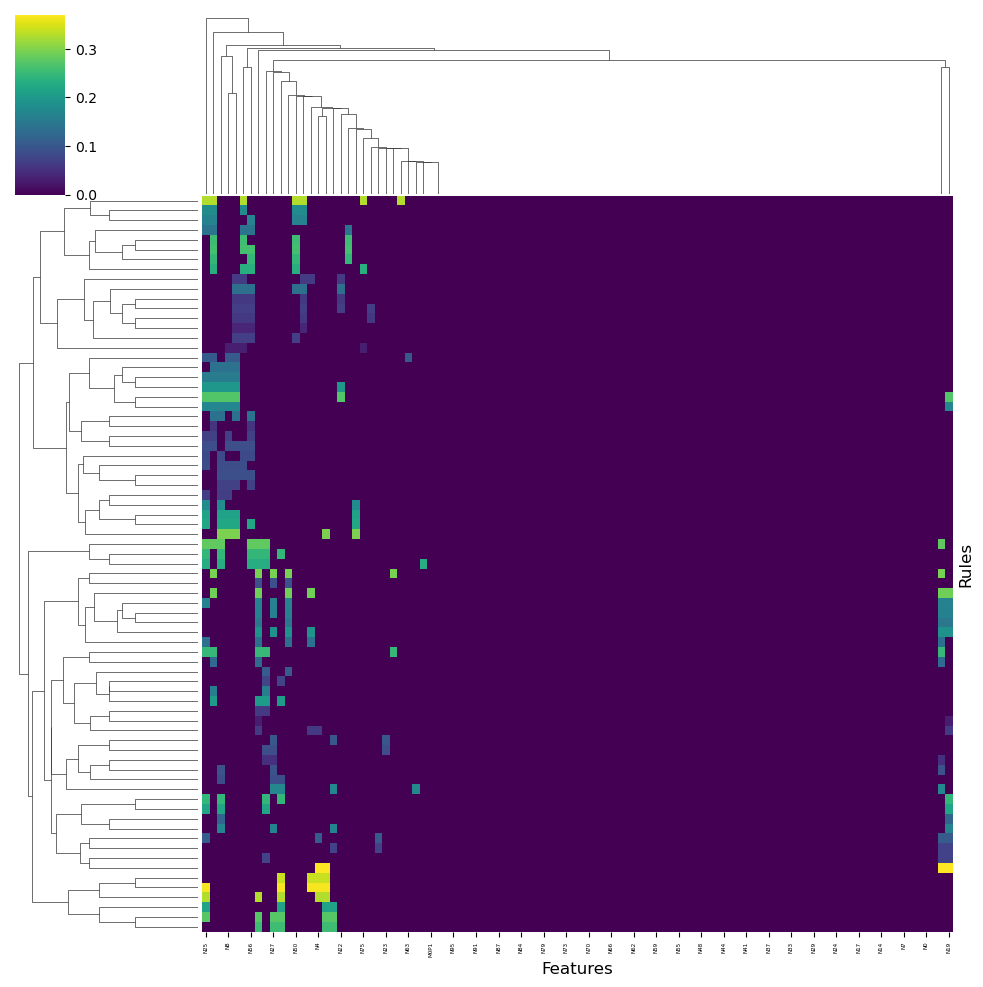

In [ ]:
model = heros_null.model_population.pop_set[0]
model.plot_rule_pop_heatmap(feature_names, heros_null, weighting='useful_accuracy', specified_filter=None, display_micro=False, show=True, save=True, output_path=folder_path, data_name=output_name)


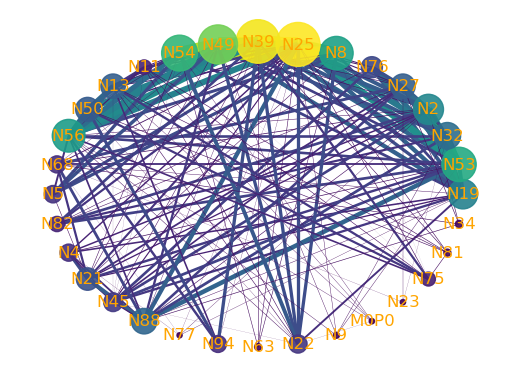

In [ ]:
model.plot_rule_pop_network(feature_names, heros_null, weighting=weighting, display_micro=display_micro, node_size=node_size, edge_size=edge_size, show=True, save=True, output_path=folder_path, data_name=output_name)

### Alt

In [ ]:
set_df = heros_alt.get_top_model_rules()
set_df.to_csv(output_folder+'/'+str(output_name)+'_top_model_rules.csv', index=False)
print(set_df)

               Condition Indexes       Condition Values  Action  Numerosity  \
0        [49, 25, 54, 8, 13, 56]     [0, 0, 0, 0, 0, 0]       1           5   
1                 [49, 8, 5, 25]           [0, 0, 1, 0]       1           2   
2                   [68, 49, 23]              [0, 1, 1]       0           1   
3            [39, 25, 2, 53, 82]        [1, 0, 0, 0, 0]       0           2   
4            [49, 25, 54, 8, 13]        [0, 0, 0, 0, 0]       1           1   
5                       [53, 19]                 [0, 0]       0           1   
6                   [68, 25, 39]              [0, 0, 1]       0           1   
7    [39, 13, 8, 25, 56, 94, 54]  [0, 0, 0, 0, 0, 1, 0]       1           2   
8                [21, 4, 88, 53]           [0, 0, 0, 0]       0           1   
9       [11, 13, 56, 54, 22, 98]     [0, 0, 0, 0, 0, 0]       1           1   
10                  [32, 88, 53]              [0, 0, 0]       0           6   
11           [2, 76, 45, 53, 19]        [0, 1, 0, 0,

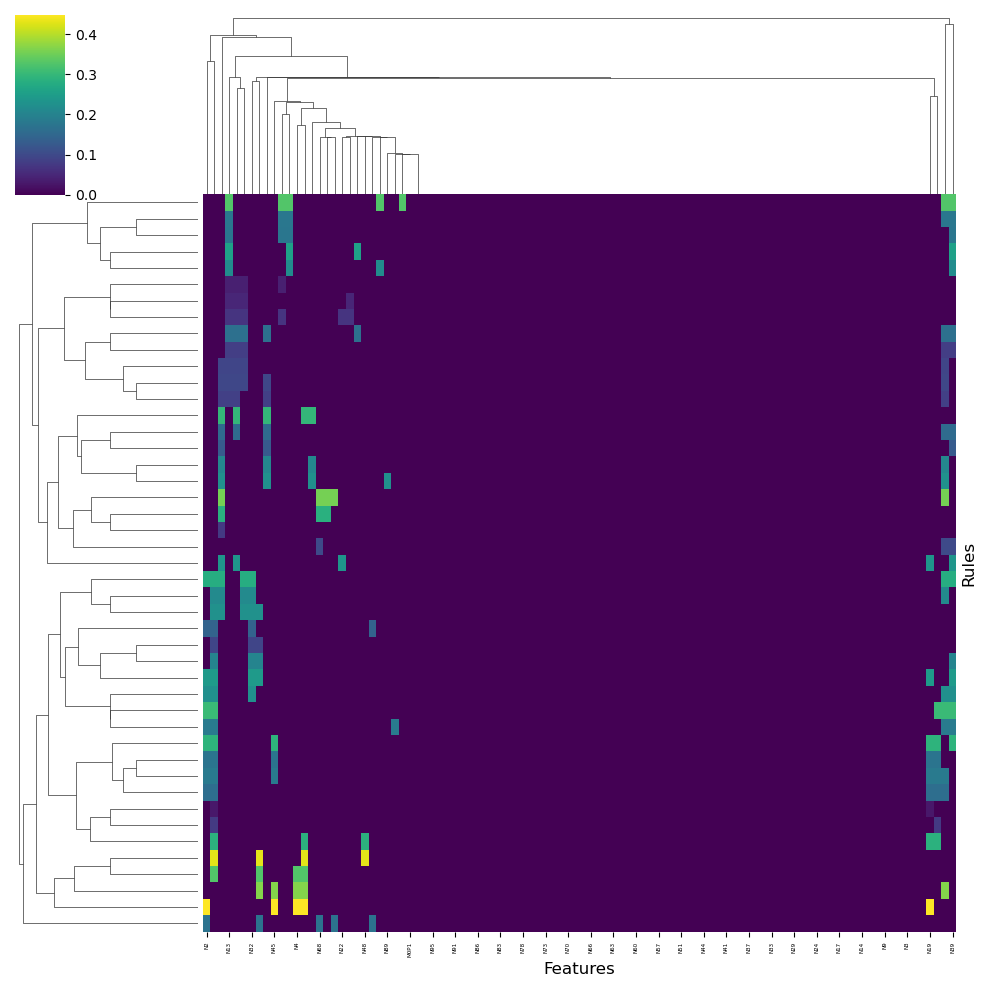

In [ ]:
model = heros_alt.model_population.pop_set[0]
model.plot_rule_pop_heatmap(feature_names, heros_alt, weighting='useful_accuracy', specified_filter=None, display_micro=False, show=True, save=True, output_path=folder_path, data_name=output_name)



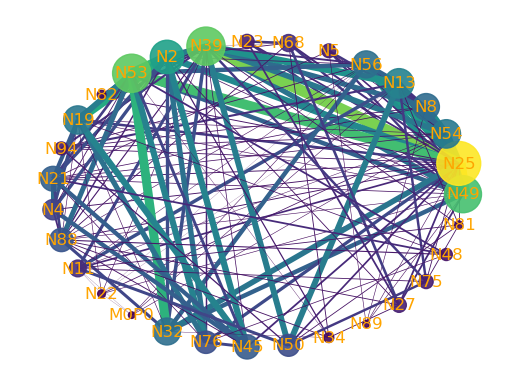

In [ ]:
model.plot_rule_pop_network(feature_names, heros_alt, weighting=weighting, display_micro=display_micro, node_size=node_size, edge_size=edge_size, show=True, save=True, output_path=folder_path, data_name=output_name)

*** 
# Performance on Test Set

### Null

In [13]:
predictions = heros_null.predict(X_test,top_rule_set=True)
print(classification_report(y_test, predictions, digits=8))

              precision    recall  f1-score   support

           0  0.47552448 0.45637584 0.46575342       149
           1  0.54237288 0.56140351 0.55172414       171

    accuracy                      0.51250000       320
   macro avg  0.50894868 0.50888967 0.50873878       320
weighted avg  0.51124659 0.51250000 0.51169402       320



### Alt

In [14]:
predictions = heros_alt.predict(X_test,top_rule_set=True)
print(classification_report(y_test, predictions, digits=8))

              precision    recall  f1-score   support

           0  0.50000000 0.42281879 0.45818182       149
           1  0.55670103 0.63157895 0.59178082       171

    accuracy                      0.53437500       320
   macro avg  0.52835052 0.52719887 0.52498132       320
weighted avg  0.53029961 0.53437500 0.52957379       320



In [ ]:
predictions = heros_alt1.predict(X_test,top_rule_set=True)
print(classification_report(y_test, predictions, digits=8))

              precision    recall  f1-score   support

           0  0.47619048 0.46979866 0.47297297       149
           1  0.54335260 0.54970760 0.54651163       171

    accuracy                      0.51250000       320
   macro avg  0.50977154 0.50975313 0.50974230       320
weighted avg  0.51208024 0.51250000 0.51227019       320



## Get Prediction Probabilities

### Null

In [ ]:
predictions = heros_null.predict_proba(X_test,top_rule_set=True)
print(predictions)

[{0: 0.34615384615384615, 1: 0.6538461538461539} {0: 0.5, 1: 0.5}
 {0: 0.21052631578947367, 1: 0.7894736842105263}
 {0: 0.6666666666666666, 1: 0.3333333333333333}
 {0: 0.5384615384615384, 1: 0.46153846153846156}
 {0: 0.7142857142857143, 1: 0.2857142857142857}
 {0: 0.3333333333333333, 1: 0.6666666666666666}
 {0: 0.42105263157894735, 1: 0.5789473684210527}
 {0: 0.17647058823529413, 1: 0.8235294117647058} {0: 0.4, 1: 0.6}
 {0: 0.3, 1: 0.7} {0: 0.2, 1: 0.8}
 {0: 0.16666666666666666, 1: 0.8333333333333334}
 {0: 0.5882352941176471, 1: 0.4117647058823529}
 {0: 0.5333333333333333, 1: 0.4666666666666667}
 {0: 0.22580645161290322, 1: 0.7741935483870968}
 {0: 0.47058823529411764, 1: 0.5294117647058824}
 {0: 0.3333333333333333, 1: 0.6666666666666666}
 {0: 0.43478260869565216, 1: 0.5652173913043478}
 {0: 0.5789473684210527, 1: 0.42105263157894735}
 {0: 0.6956521739130435, 1: 0.30434782608695654} {0: 0.5, 1: 0.5}
 {0: 0.19230769230769232, 1: 0.8076923076923077} {0: 0.125, 1: 0.875}
 {0: 0.6451612903

### Alt

In [ ]:
predictions = heros_alt.predict_proba(X_test,top_rule_set=True)
print(predictions)

[{0: 0.18181818181818182, 1: 0.8181818181818182} {0: 1.0, 1: 0.0}
 {0: 0.2727272727272727, 1: 0.7272727272727273}
 {0: 0.6666666666666666, 1: 0.3333333333333333}
 {0: 0.6666666666666666, 1: 0.3333333333333333}
 {0: 0.8695652173913043, 1: 0.13043478260869565} {0: 0.5, 1: 0.5}
 {0: 0.2857142857142857, 1: 0.7142857142857143}
 {0: 0.3333333333333333, 1: 0.6666666666666666} {0: 0.375, 1: 0.625}
 {0: 0.2222222222222222, 1: 0.7777777777777778}
 {0: 0.14285714285714285, 1: 0.8571428571428571}
 {0: 0.16666666666666666, 1: 0.8333333333333334}
 {0: 0.5833333333333334, 1: 0.4166666666666667}
 {0: 0.5714285714285714, 1: 0.42857142857142855} {0: 0.1875, 1: 0.8125}
 {0: 0.42857142857142855, 1: 0.5714285714285714} {0: 0.25, 1: 0.75}
 {0: 0.5, 1: 0.5} {0: 0.6190476190476191, 1: 0.38095238095238093}
 {0: 0.7272727272727273, 1: 0.2727272727272727} {0: 0.5, 1: 0.5}
 {0: 0.16666666666666666, 1: 0.8333333333333334} {0: 0.125, 1: 0.875}
 {0: 0.6428571428571429, 1: 0.35714285714285715} {0: 1.0, 1: 0.0}
 {0: 0

In [ ]:
predictions = heros_alt1.predict_proba(X_test,top_rule_set=True)
print(predictions)

[{0: 0.3076923076923077, 1: 0.6923076923076923} {0: 0.5, 1: 0.5}
 {0: 0.17647058823529413, 1: 0.8235294117647058} {0: 0.6, 1: 0.4}
 {0: 0.6470588235294118, 1: 0.35294117647058826}
 {0: 0.7941176470588235, 1: 0.20588235294117646}
 {0: 0.16666666666666666, 1: 0.8333333333333334}
 {0: 0.3157894736842105, 1: 0.6842105263157895}
 {0: 0.21739130434782608, 1: 0.782608695652174}
 {0: 0.35135135135135137, 1: 0.6486486486486487}
 {0: 0.30434782608695654, 1: 0.6956521739130435}
 {0: 0.11538461538461539, 1: 0.8846153846153846}
 {0: 0.23529411764705882, 1: 0.7647058823529411}
 {0: 0.5416666666666666, 1: 0.4583333333333333}
 {0: 0.5333333333333333, 1: 0.4666666666666667}
 {0: 0.23684210526315788, 1: 0.7631578947368421}
 {0: 0.5238095238095238, 1: 0.47619047619047616}
 {0: 0.46153846153846156, 1: 0.5384615384615384}
 {0: 0.4444444444444444, 1: 0.5555555555555556}
 {0: 0.5909090909090909, 1: 0.4090909090909091}
 {0: 0.6774193548387096, 1: 0.3225806451612903}
 {0: 0.47368421052631576, 1: 0.526315789473

*** 
# Learning Rate Comparison

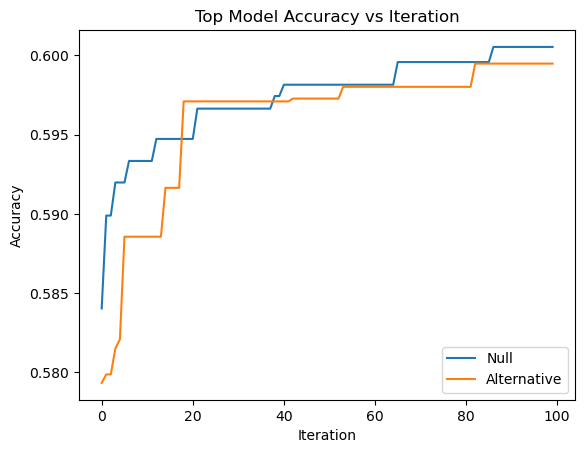

In [15]:
top_models_null = heros_null.export_model_growth()
top_models_alt = heros_alt.export_model_growth()
top_models_alt1 = heros_alt1.export_model_growth()
plt.plot(top_models_null.index, top_models_null["Accuracy"], label = "Null")
plt.plot(top_models_alt.index, top_models_alt["Accuracy"], label = "Alternative")
plt.plot(top_models_alt1.index, top_models_alt1["Accuracy"], label = "Alternative")
# Add labels and title
plt.xlabel('Iteration')
plt.ylabel("Accuracy")
plt.title(f'{"Top Model Accuracy"} vs Iteration')
plt.legend(loc='lower right')
# Show plot
plt.show()